# Машинное обучение

Достаточно очевидно, что для нашего датасета было бы неплохо обучить модель, предсказывающую цены на машины. В прошлом мы получили финальную версию датасета, убрав оттуда все повторы и пропуски, а также добавив новые признаки. Тем не менее, нужно разобраться с выбросами, так как они могут сильно ухудшить результаты регрессии. 

Начнём с этого!

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
from features_weight import show_weights
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
df = pd.read_csv('final_data.csv', index_col='Unnamed: 0')
df.head()

,Модель,Цена,Год выпуска,Пробег,Привод,ЛС,Тип двигателя,Тип кузова,Коробка передач,Объём двигателя,Цвет,Марка,Класс,Налог
0,Kia Carnival IV,4379000,2020,26000,передний,202,Дизель,минивэн,автомат,2.2,чёрный,Kia,4,14443
1,Kia Carnival III,2519000,2018,43000,передний,202,Дизель,минивэн,автомат,2.2,чёрный,Kia,3,13130
2,Tesla Model X Plaid I Рестайлинг,15490000,2022,70,полный,1020,Электро,внедорожник 5 дв.,автомат,2.4,чёрный,Tesla,5,0
3,LADA (ВАЗ) Vesta I,1330000,2021,9000,передний,113,Бензин,седан,вариатор,1.6,белый,LADA,2,2825
4,McLaren 765LT,59500000,2021,1311,задний,765,Бензин,купе,робот,4.0,фиолетовый,McLaren,5,344250


# Предобработка

In [4]:
df.describe(percentiles=[.25, .5, .75, .95, .99])

,Цена,Год выпуска,Пробег,ЛС,Объём двигателя,Класс,Налог
count,2.558000e+03,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000
mean,4.176280e+06,2016.379593,94519.657545,210.232995,2.408249,3.001564,32387.825254
std,5.999969e+06,5.687275,80290.144510,113.675497,0.992336,1.413106,53703.822591
min,3.850000e+04,1961.000000,1.000000,45.000000,0.700000,1.000000,0.000000
25%,1.180000e+06,2013.000000,31000.000000,136.000000,1.600000,2.000000,4550.000000
50%,2.250000e+06,2018.000000,77000.000000,180.000000,2.000000,3.000000,9200.000000
75%,5.127750e+06,2020.000000,142345.750000,249.000000,3.000000,4.000000,37350.000000
95%,1.381500e+07,2022.000000,246208.300000,435.000000,4.500000,5.000000,153000.000000
99%,2.690000e+07,2023.000000,329385.710000,612.000000,6.000000,5.000000,263250.000000
max,1.350000e+08,2023.000000,600000.000000,1020.000000,6.800000,5.000000,344250.000000


Как можно заметить даже отсюда, с большой вероятноcтью в таких признаках, как 'Цена', 'ЛС' и 'Налог' имеются выбросы. Удалим их, чтобы в дальнейшем это не сказалось на качестве модели.

## Пробег

Среди наблюдений есть машины с очень большим пробегом и они составляют очень небольшую часть выборки

<AxesSubplot:title={'center':'После удаления выбросов'}>

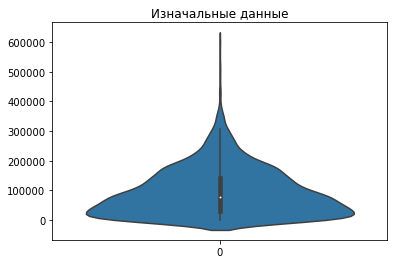

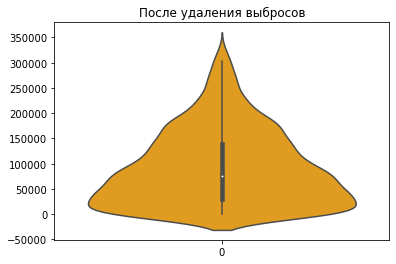

In [5]:
plt.title('Изначальные данные')
sns.violinplot(data=df['Пробег'])
df = df.loc[df['Пробег'] < df['Пробег'].quantile(0.99)]
plt.figure()
plt.title('После удаления выбросов')
sns.violinplot(data=df['Пробег'], color='orange')

Как можно заметить, после того, как мы отсекли данные по 99 квантилю, violinplot стал выглядеть намного более приятно.

## Цена

<AxesSubplot:title={'center':'После удаления выбросов'}>

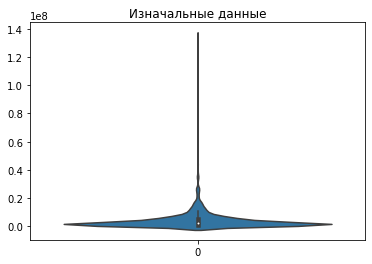

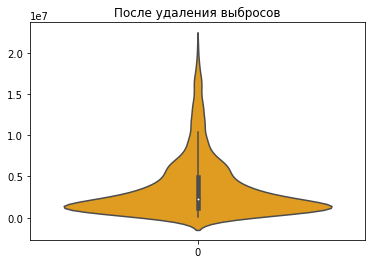

In [6]:
plt.title('Изначальные данные')
sns.violinplot(data=df['Цена'])
df = df.loc[df['Цена'] < df['Цена'].quantile(0.98)]
plt.figure()
plt.title('После удаления выбросов')
sns.violinplot(data=df['Цена'], alpha=0.25, color='orange')

Как можно заметить, после того, как мы отсекли данные по 98 квантилю, violinplot стал выглядеть намного более приятно.

## Мощность

Сделаем всё то же самое и для машин со слишком высокой мощностью

<AxesSubplot:title={'center':'После удаления выбросов'}>

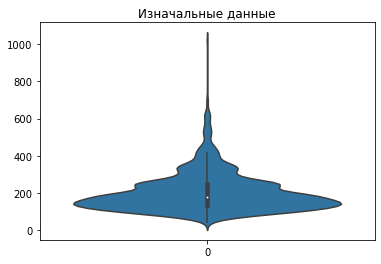

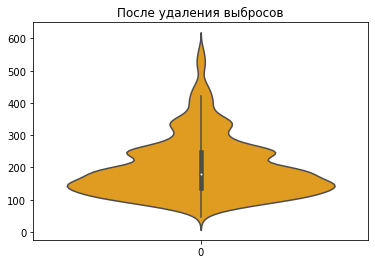

In [7]:
plt.title('Изначальные данные')
sns.violinplot(data=df['ЛС'])
df = df.loc[df['ЛС'] < df['ЛС'].quantile(0.99)]
plt.figure()
plt.title('После удаления выбросов')
sns.violinplot(data=df['ЛС'], alpha=0.25, color='orange')

## Налоги

Поскольку налог напрямую зависит от цены и лошадиных сил, удаление выбросов по этим параметрам могло удалить и выбросы по размеру налога

<AxesSubplot:title={'center':'После удаления выбросов'}>

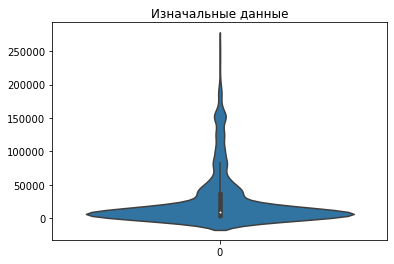

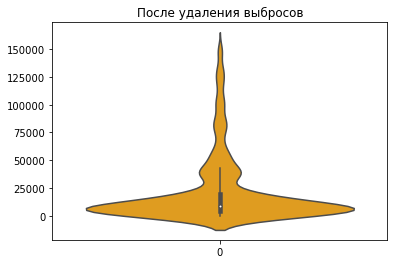

In [8]:
plt.title('Изначальные данные')
sns.violinplot(data=df['Налог'])
df = df.loc[df['Налог'] < df['Налог'].quantile(0.98)]
plt.figure()
plt.title('После удаления выбросов')
sns.violinplot(data=df['Налог'], alpha=0.25, color='orange')

Отлично! Теперь перейдем к нормализации.

# Нормализация

Как было замечано ранее, в датасете есть как числовые признаки, так и категориальные.

Числовые данные отнормируем при помощи минимаксной процедуры, а категориальные — с помощью метода __get_dummies()__.

In [9]:
df = pd.get_dummies(df) # Из категориальных переменных создаем много бинарных

x_train, x_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Цена'],
                                        df['Цена'], test_size=0.2, random_state=42)

In [10]:
scaler = MinMaxScaler() # нормируем данные от 0 до 1

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Модель

В ходе обучения попробуем как Lasso-регрессия, так и Ridge, а также иные регрессионные методы, потом выберем наилучший результат.

## Lasso-регрессия

При обучении Lasso-регрессия использует L1-регуляризация, чтобы не допустить переобучения. В нашей ситуации это достаточно вероятно, так как признаков очень много и модель без регуляризации быстро приходит к переобучению. Выберем наилучший коэффициент регулярции при помощи поиска по сетке.

MSE: 646900249628.3202
MAE: 439527.68971173913
R2: 0.9207641014097439
MAPE: 0.23979682837266608


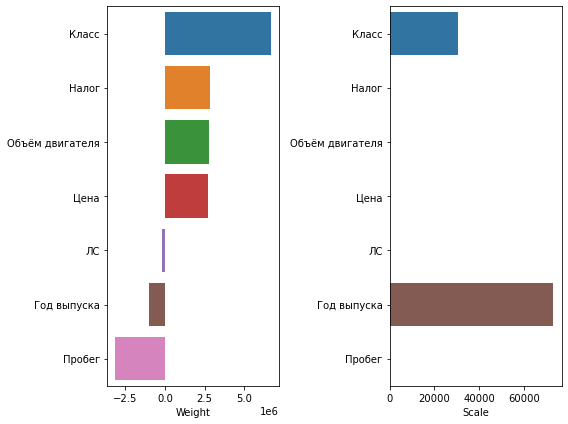

In [11]:
alphas = np.logspace(2, 4, 20)
searcherl = GridSearchCV(Lasso(), 
                        [{'alpha': alphas}], scoring="neg_mean_absolute_error", cv=10, n_jobs=-1)
searcherl.fit(x_train_scaled, y_train)
modell = Lasso(alpha = searcherl.best_params_["alpha"])
modell.fit(x_train_scaled, y_train)
prediction = modell.predict(x_test_scaled)

print(f'MSE: {mean_squared_error(y_test, prediction)}')
print(f'MAE: {mean_absolute_error(y_test, prediction)}')
print(f'R2: {r2_score(y_test, prediction)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, prediction)}')
show_weights(df.columns[:7], modell.coef_[:7], x_train.iloc[:, :7].std())

Такими получились результаты. Кроме того, можно посмотреть, какие признаки получили наибольший вес. Удивительно, что мощность слегка отрицательно влияет на цену.

## Ridge-регрессия

Протестируем модель с ridge-регрессией, поиск гиперпараметров также произведем с помощью поиска по сетке.

MSE: 618626823691.5326
MAE: 472143.4455703722
R2: 0.9242271860377271
MAPE: 0.2852677676721101


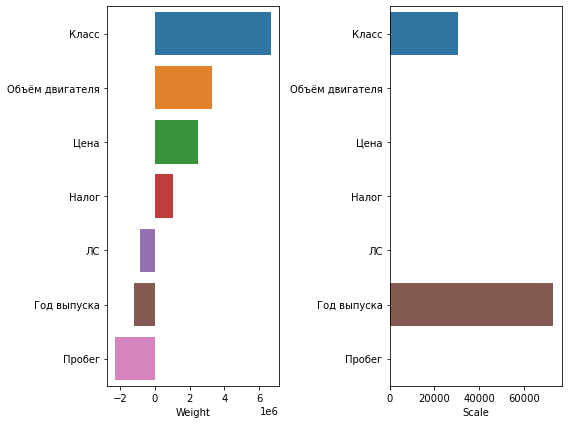

In [16]:
alphas = np.logspace(-2, 4, 100)
searcherr = GridSearchCV(Ridge(), [{'alpha': alphas}], scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcherr.fit(x_train_scaled, y_train)
modelr = Ridge(alpha = searcherr.best_params_["alpha"])
modelr.fit(x_train_scaled, y_train)
prediction = modelr.predict(x_test_scaled)

print(f'MSE: {mean_squared_error(y_test, prediction)}')
print(f'MAE: {mean_absolute_error(y_test, prediction)}')
print(f'R2: {r2_score(y_test, prediction)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, prediction)}')
show_weights(df.columns[:7], modelr.coef_[:7], x_train.iloc[:, :7].std())

## GradientBoosting-регрессия

MSE: 334879194056.20557
MAE: 375109.3547902766
R2: 0.9589821554784224
MAPE: 0.1920195580201132


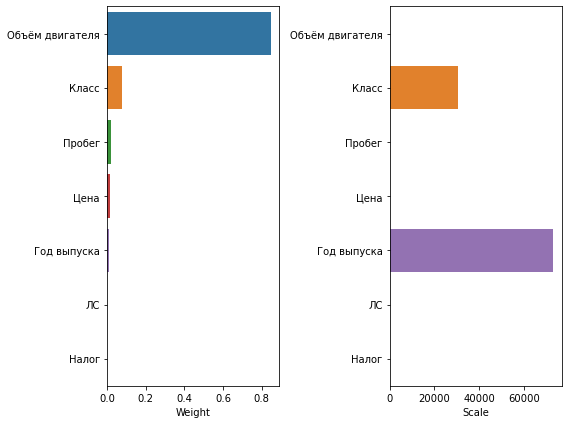

In [14]:
modelg = GradientBoostingRegressor(random_state=42)
modelg.fit(x_train_scaled, y_train)
prediction = modelg.predict(x_test_scaled)

print(f'MSE: {mean_squared_error(y_test, prediction)}')
print(f'MAE: {mean_absolute_error(y_test, prediction)}')
print(f'R2: {r2_score(y_test, prediction)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, prediction)}')
show_weights(df.columns[:7], modelg.feature_importances_[:7], x_train.iloc[:, :7].std())

### Вывод
Самым эффективной моделью (по всем метрикам) оказалась GradientBoosting регрессия с cредней абсолютной ошибкой в 375 тыс рублей.

Стоит заметить, что средняя цена на машину в данном датасете - 3 147 820 рублей, то есть ошибка не превышает 19,2% от цены. В случае с покупокой машины / оценкой стоимости машины такая погрешность не является критичной (если задуматься о прикладной стороне данного проекта), так как разница в 400 тыс при приобретении машины за 3 млн не сильно влияет на решение о покупке.

Выше можно наблюдать важность различных параметров в линейной модели для определения цены и - что более важно и интересно - их знак.

Так, чёрный, белый и серебристый цвета добавляют в цене, при этом все остальные наоборот (это явление ещё будет описано в гипотезах). Также можно видеть, что год выпуска имеет положительный вес, также как класс автомобиля (потому что, чем выше класс, тем дороже) и размер налога (так как налог зависит от цены и ЛС, а цена зависит от ЛС), меж тем как пробег (что логично), ЛС и объём двигателя влияют отрицательно (что странно, но вероятно может быть объяснено особенностями рынка автомобилей).

Также объяснимы знаки при марках машины - производители более премиального класса добавляют к цене, тогда как не столь премиального - уменьшают.

В модели с градиентным бустингом используется более сложный алгоритм, предусматривающий обучение на отрицательном градиенте функций потерь при обучении, и поэтому даёт меньшую ошибку и больший коэффицент детерминации, хотя показывает существенно меньше интересных выводов о ценообразовании на московском авторынке.